# Provo a ritagliare i file scaricati tramite ftp

apro tutti gli nc di ogni mese, li croppo e li salvo nella cartella di lavoro


In [13]:
# import libraries for working with .nc
import xarray as xr
import os   
import numpy as np




In [5]:
# origin path

path =  '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily/'


carico un file di esempio

In [7]:
year = 2022
month = 6
# load this file s_subset.to_netcdf(outp + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month), encoding=encoding)as a xarray dataset
ds = xr.open_dataset(path + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month))


  # save the subset to a NetCDF file with the updated encoding (nome file= outp + year + 'CHL_03-10_{}_.nc'.format(year))
 #       ds_subset.to_netcdf(outp + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month), encoding=encoding)
               
ds


<xarray.Dataset>
Dimensions:    (time: 30, latitude: 1248, longitude: 5280)
Coordinates:
  * time       (time) datetime64[ns] 2022-06-01 2022-06-02 ... 2022-06-30
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.984 -4.974 ... 49.97 49.98 49.99
Data variables:
    CHL        (time, latitude, longitude) float32 ...

interpolo la longitudine

aggrego 5 celle

In [32]:
# Calculate the differences in latitudes and longitudes
delta_latitude = abs(ds.latitude.values[1] - ds.latitude.values[0])
delta_longitude = abs(ds.longitude.values[1] - ds.longitude.values[0])

print(f"Spatial resolution (latitude): {delta_latitude} degrees")
print(f"Spatial resolution (longitude): {delta_longitude} degrees")



Spatial resolution (latitude): 0.010416666666671404 degrees
Spatial resolution (longitude): 0.010416666666685614 degrees


In [15]:
# Calculate the average latitude of the dataset
avg_latitude = ds.latitude.mean().values

# Convert the average latitude from degrees to radians
avg_latitude_rad = np.deg2rad(avg_latitude)

# Calculate the spatial resolution in meters
resolution_latitude_m = delta_latitude * 111000
resolution_longitude_m = delta_longitude * 111000 * np.cos(avg_latitude_rad)

print(f"Spatial resolution (latitude): {resolution_latitude_m} meters")
print(f"Spatial resolution (longitude): {resolution_longitude_m} meters")

resolution_latitude_m / resolution_longitude_m

Spatial resolution (latitude): 1156.2500000005257 meters
Spatial resolution (longitude): 230.51917417030356 meters


5.015851736247798

In [33]:
np.arange(ds.longitude[0], ds.longitude[-1], step = 5 * delta_longitude)

5 * delta_longitude

0.05208333333342807

In [34]:
ds_coarsened = ds.interp(longitude=np.arange(ds.longitude[0], ds.longitude[-1], step = 5 * delta_longitude), method='nearest')


print(ds_coarsened)

<xarray.Dataset>
Dimensions:    (time: 30, latitude: 1248, longitude: 1056)
Coordinates:
  * time       (time) datetime64[ns] 2022-06-01 2022-06-02 ... 2022-06-30
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
Data variables:
    CHL        (time, latitude, longitude) float32 nan nan nan ... 0.141 0.1427


ricontrollo la risoluzione

In [35]:
# Calculate the differences in latitudes and longitudes
delta_latitude = abs(ds_coarsened.latitude.values[1] - ds_coarsened.latitude.values[0])
delta_longitude = abs(ds_coarsened.longitude.values[1] - ds_coarsened.longitude.values[0])

print(f"Spatial resolution (latitude): {delta_latitude} degrees")
print(f"Spatial resolution (longitude): {delta_longitude} degrees")

0.0104 *5

Spatial resolution (latitude): 0.010416666666671404 degrees
Spatial resolution (longitude): 0.05208333333342807 degrees


0.052

In [36]:
# Calculate the average latitude of the dataset
avg_latitude = ds_coarsened.latitude.mean().values

# Convert the average latitude from degrees to radians
avg_latitude_rad = np.deg2rad(avg_latitude)

# Calculate the spatial resolution in meters
resolution_latitude_m = delta_latitude * 111000
resolution_longitude_m = delta_longitude * 111000 * np.cos(avg_latitude_rad)

print(f"Spatial resolution (latitude): {resolution_latitude_m} meters")
print(f"Spatial resolution (longitude): {resolution_longitude_m} meters")

resolution_latitude_m / resolution_longitude_m

Spatial resolution (latitude): 1156.2500000005257 meters
Spatial resolution (longitude): 1152.5958708515177 meters


1.0031703472495597

le celle sono quasi quadrate!

In [39]:
# creo la cartella path =  '/mnt/d/Dropbox/R_projects/SV_phenology/data/test_coarsened e salvo il file
# creo la cartella
os.mkdir('/mnt/d/Dropbox/R_projects/SV_phenology/data/test_coarsened')
ds_coarsened.to_netcdf('/mnt/d/Dropbox/R_projects/SV_phenology/data/test_coarsened' + '/CHL_03-10_{}_{}_coarsened.nc'.format(year, month))


In [40]:

def dineof(ds, var_name, num_eofs):
    # Stack the dataset into a 2D matrix (time x space)
    stacked = ds[var_name].stack(space=['latitude', 'longitude'])
    
    # Remove missing values and store their indices
    missing_values = np.isnan(stacked)
    valid_data = np.where(~missing_values, stacked, 0)
    
    # Perform singular value decomposition (SVD)
    U, s, V = np.linalg.svd(valid_data, full_matrices=False)
    
    # Select the number of EOFs for reconstruction
    U = U[:, :num_eofs]
    s = s[:num_eofs]
    V = V[:num_eofs, :]
    
    # Reconstruct the data
    reconstructed_data = np.dot(U * s, V)
    
    # Fill the missing values in the original dataset with the reconstructed data
    filled_data = np.where(missing_values, reconstructed_data, stacked)
    
    # Unstack the filled data back to the original dimensions
    filled_data = xr.DataArray(
        filled_data,
        dims=stacked.dims,
        coords=stacked.coords,
    ).unstack('space')
    
    # Replace the original variable with the filled data in the dataset
    ds_filled = ds.copy()
    ds_filled[var_name] = filled_data
    
    return ds_filled

In [41]:

# Example usage
num_eofs = 8
filled_ds = dineof(ds_coarsened, 'CHL', num_eofs)

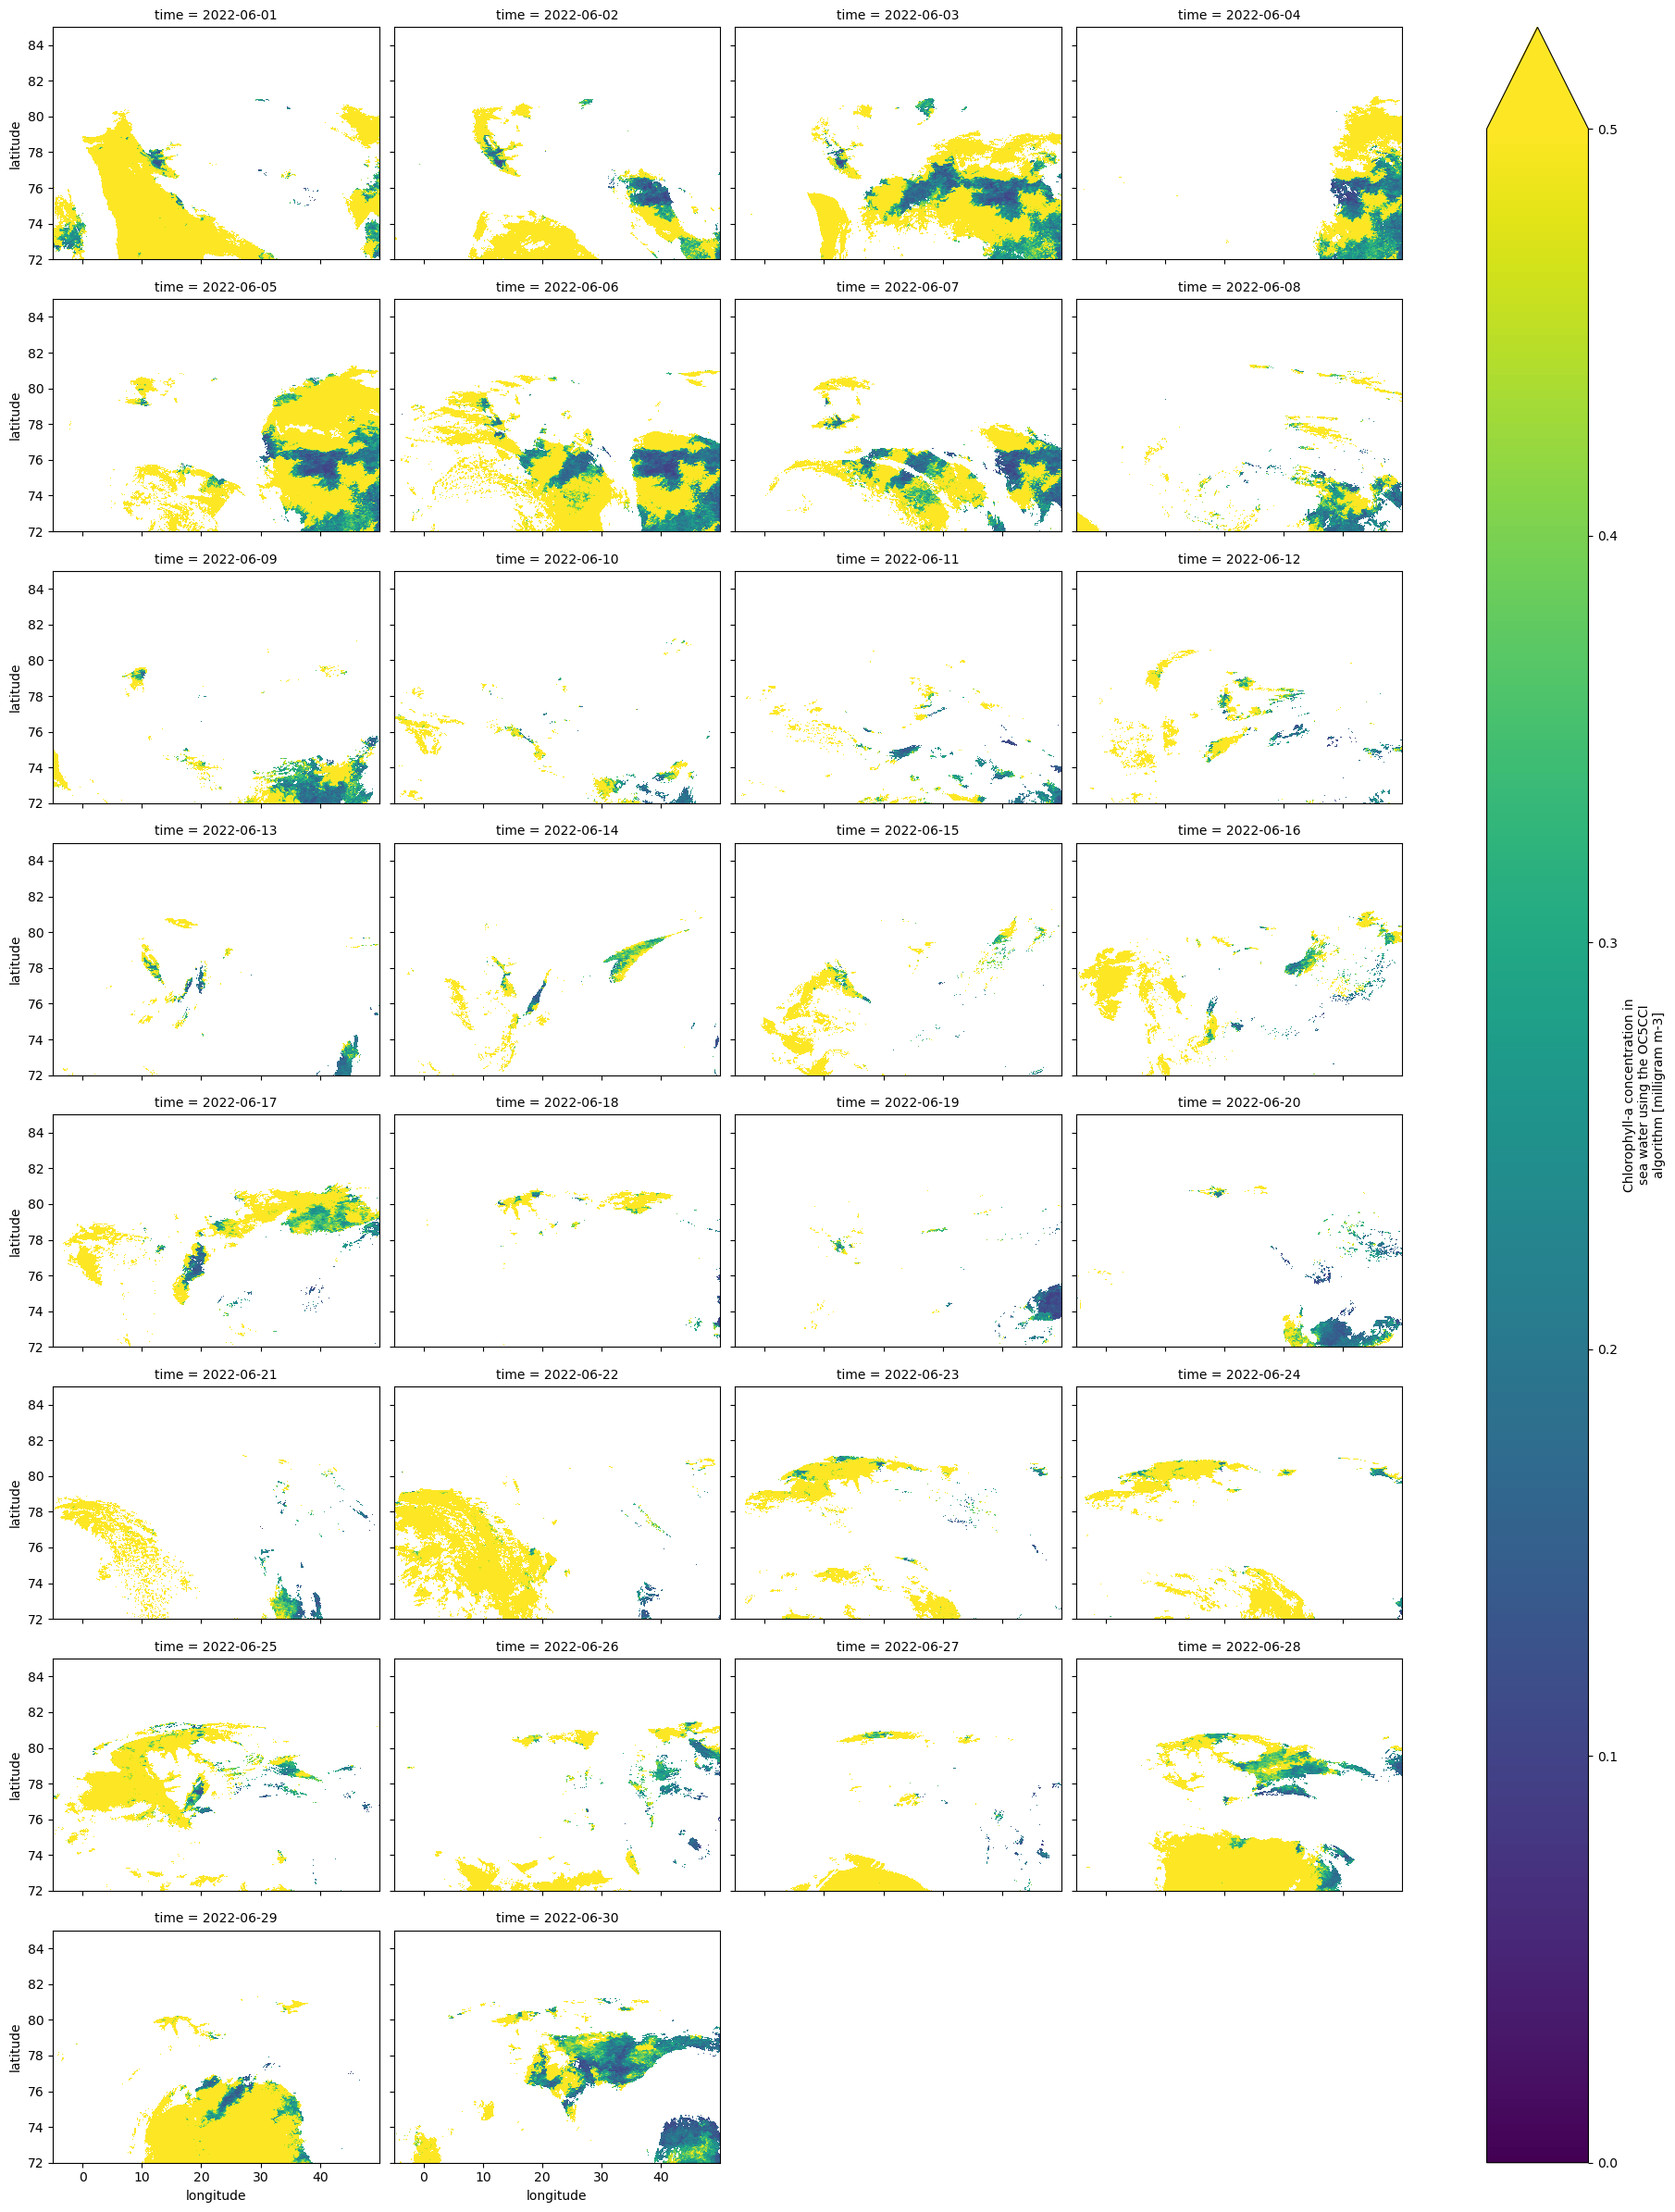

In [46]:
# plot ds_coarsened (daily map)
ds_coarsened['CHL'].plot(col='time', col_wrap=4, cmap='viridis', vmin=0, vmax=0.5, size=3, aspect=1.5)

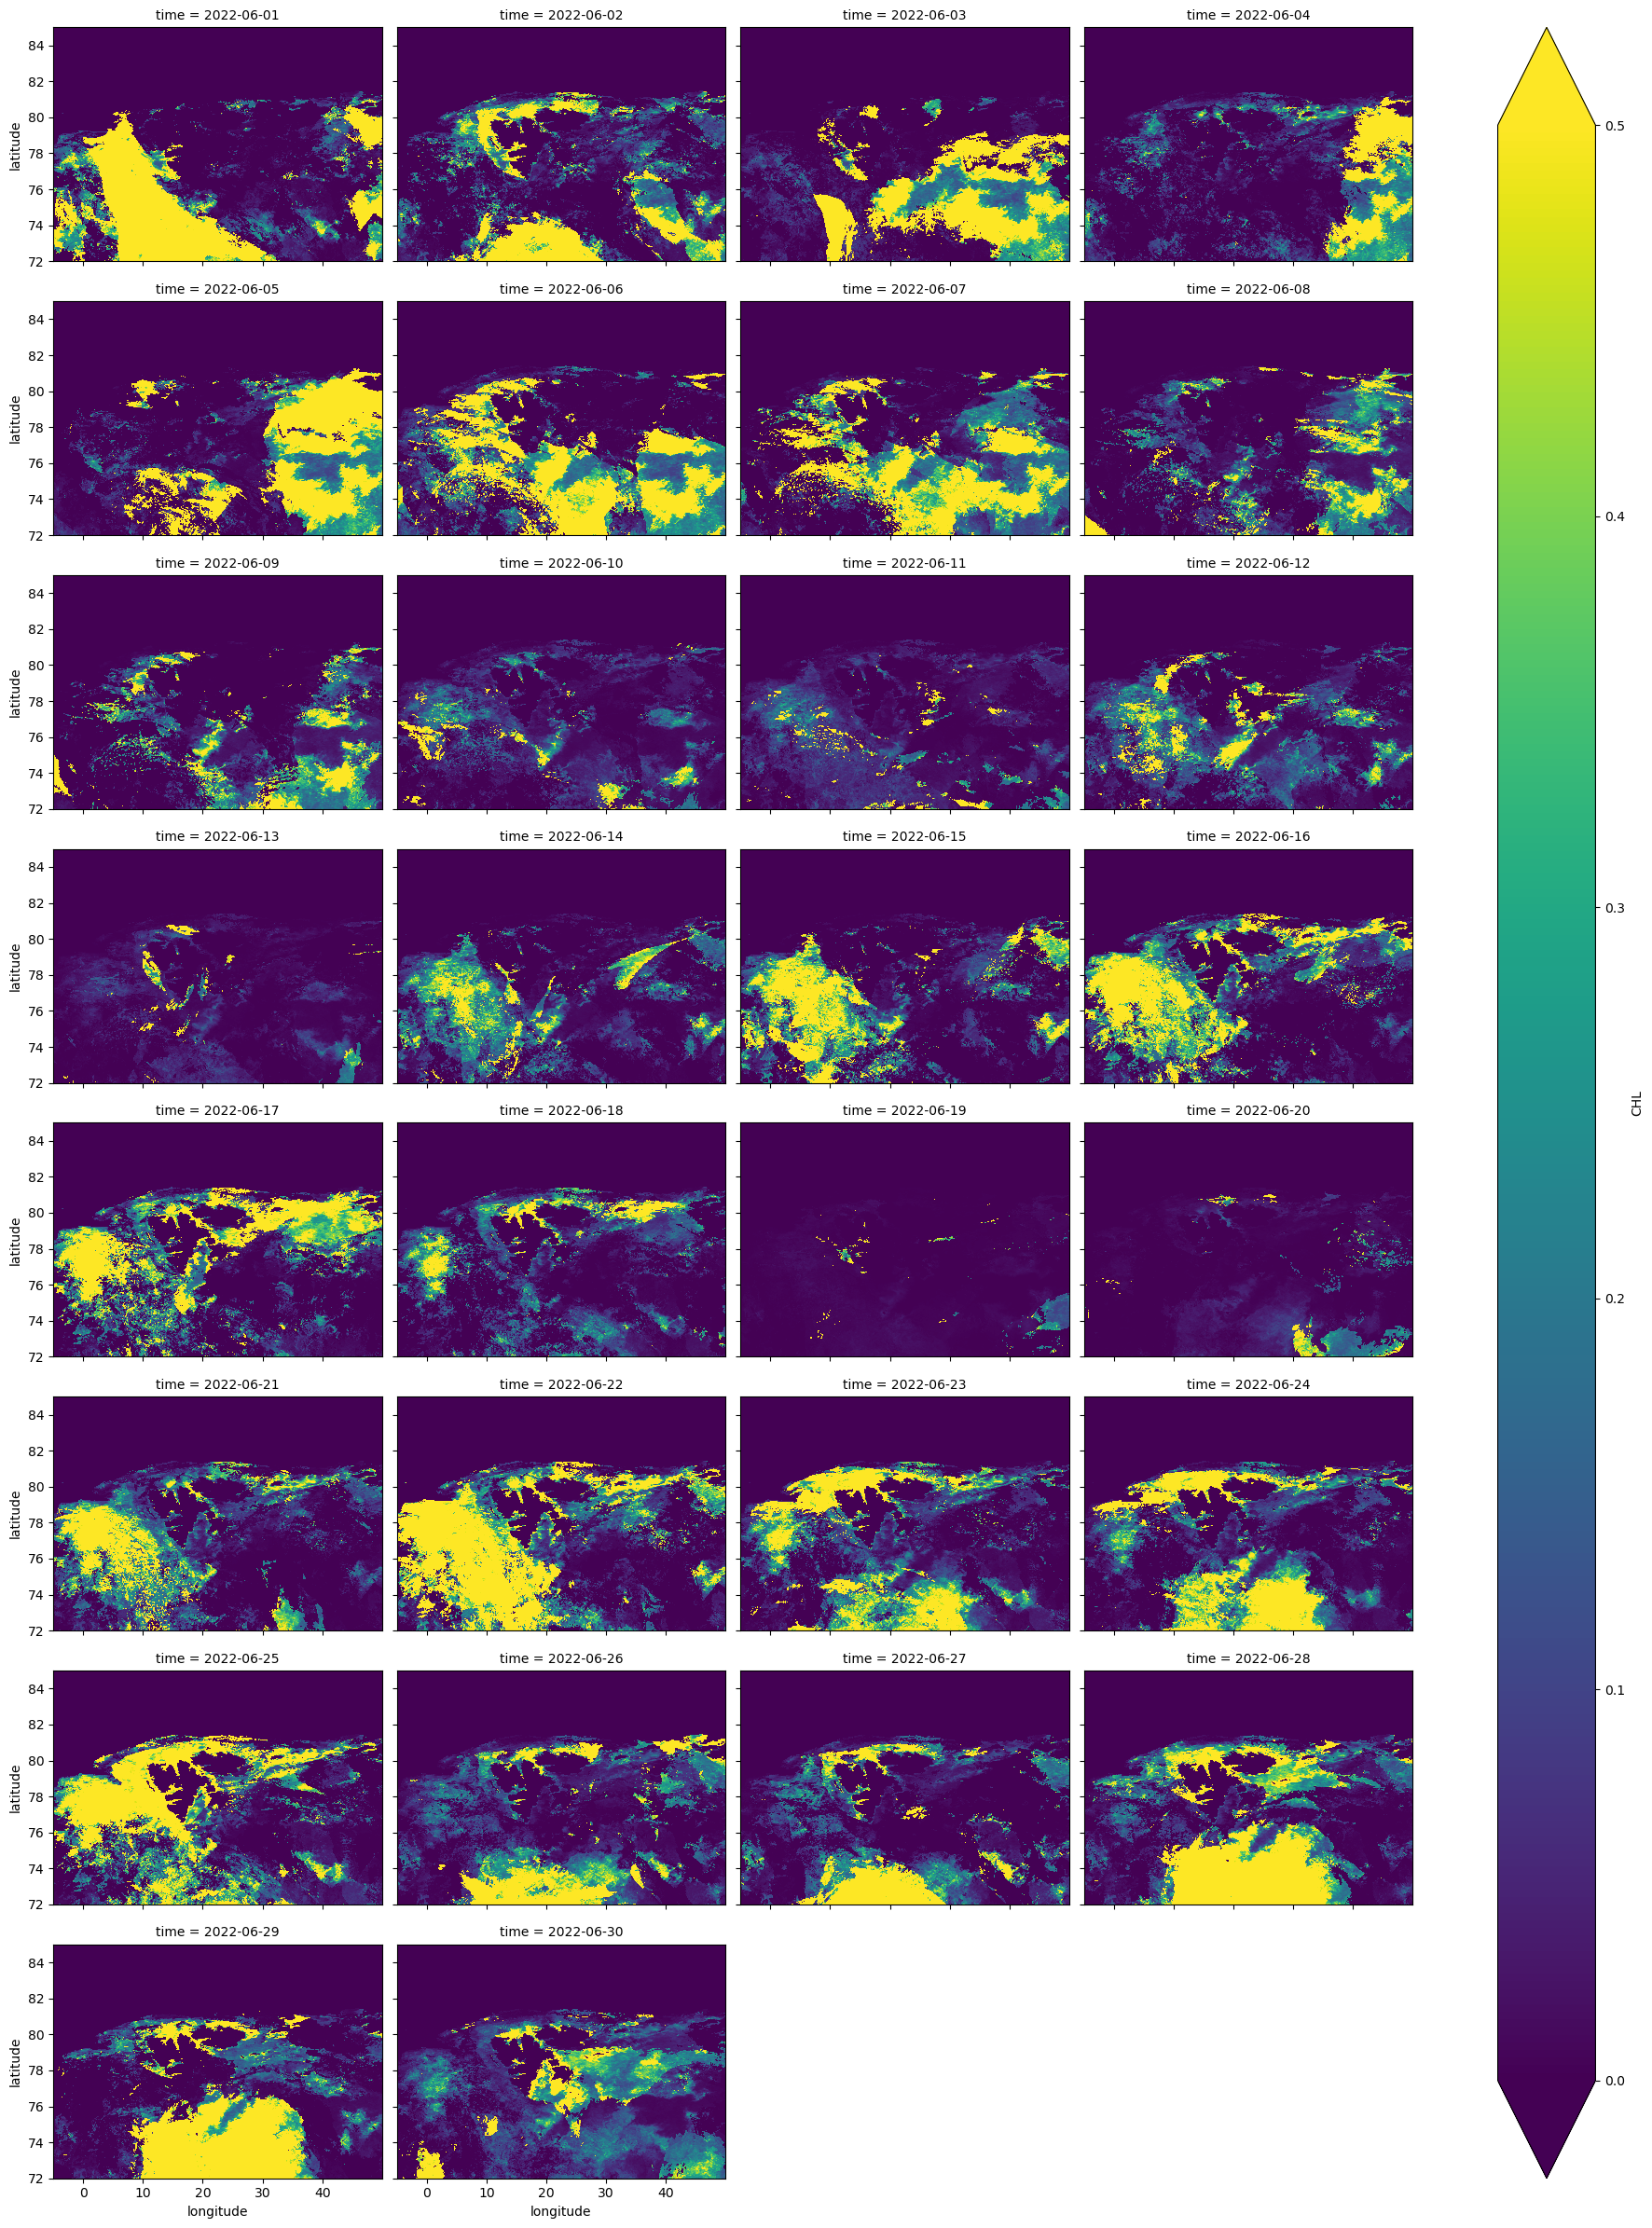

In [47]:
filled_ds['CHL'].plot(col='time', col_wrap=4, cmap='viridis', vmin=0, vmax=0.5, size=3, aspect=1.5)

In [ ]:
# now open also month 07 and 08, interpolate at the same resolution and stack them together (with ds_coarsened)


def open_and_interpolate(year, month):
    file_path = f"{path}{year}/CHL_03-10_{year}_{month}.nc"
    ds = xr.open_dataset(file_path)
    
    # Create a new longitude coordinate with 5 times coarser resolution
    new_longitude = np.linspace(ds.longitude[0], ds.longitude[-1], num=(len(ds.longitude) - 1) // 5 + 1)

    # Interpolate the dataset to the new longitude coordinate
    ds_interp = ds.interp(longitude=np.arange(ds.longitude[0], ds.longitude[-1], step = 5 * delta_longitude), method='nearest')

    
    return ds_interp

year = 2022

# Open and interpolate the datasets for months 06, 07, and 08
ds_month_06 = open_and_interpolate(year, 6)
ds_month_07 = open_and_interpolate(year, 7)
ds_month_08 = open_and_interpolate(year, 8)

# Stack the interpolated datasets along the time dimension
ds_3M= xr.concat([ds_month_06, ds_month_07, ds_month_08], dim='time')

# Display the stacked dataset
ds_3M.to_netcdf('/mnt/d/Dropbox/R_projects/SV_phenology/data/test_coarsened' + '/CHL_3M_coarsened.nc')


In [8]:
# loop for each year within 1998 and 2022
for year in range(1998,2023):
    # loop for each month within march and october

    # create a folder for each year
    #os.mkdir(outp + '{}'.format(year))

    for month in range(10, 11):
        # temp path concatenate folder for year and month (e.g. 1998/03), with month in two digits
        tpath = 'F:/CMEMS/cmems_obs-oc_arc_bgc-plankton_my_l3-multi-1km_P1M/{:04d}/{:02d}'.format(year,month)


        # list all files
        files = [os.path.join(tpath, f) for f in os.listdir(tpath)]

        # use xarray to stack all files in files
        ds = xr.open_mfdataset(files, combine='by_coords')

        # subset with latitudes 
        ds_subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

        

        # subset only CHL values to save
        ds_subset = ds_subset['CHL']

        # set consistent _FillValue and missing_value attributes for the 'CHL' variable
        encoding = {'CHL': {'_FillValue': -999.0, 'missing_value': -999.0}}

        # save the subset to a NetCDF file with the updated encoding (nome file= outp + year + 'CHL_03-10_{}_.nc'.format(year))
        ds_subset.to_netcdf(outp + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month), encoding=encoding)
               


        # plot the subset title='CHL_03-10_{}'.format(year) title='CHL_03-10_{}_{}'.format(year, month)
        #ds_subset.plot(col='time', col_wrap=4, cmap='viridis', vmin=0, vmax=0.5, size=3, aspect=1.5)


        # close the dataset
        ds.close()

        # close the subset
        ds_subset.close()

        # print the year and month
        print(year, month)
        




 

2022 3
2022 4
2022 5
2022 6
2022 7
2022 8
2022 9
